#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 10:20 AM EST, Saturday, March 19, 2016  
W261-3, Spring 2016  
Week 9 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW9/MIDS-W261-2015-HWK-Week09-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/s/wp4cz1e0bif1k76/HW9-Assignment.txt?dl=0)**
- [Raw data on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)
- [PageRank in Wikipedia](https://en.wikipedia.org/wiki/PageRank)  
- [Topic-Specific PageRank](http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf)


In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

In [86]:
#Use this line of code to kick off a persistent cluster
!python -m mrjob.tools.emr.create_job_flow '--conf-path' 'mrjob.conf'

creating new scratch bucket mrjob-67a1f4bb719f27a3
using s3://mrjob-67a1f4bb719f27a3/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160318.225015.836477
writing master bootstrap script to /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/no_script.nicholashamlin.20160318.225015.836477/b.py
creating S3 bucket 'mrjob-67a1f4bb719f27a3' to use as scratch space
Copying non-input files into s3://mrjob-67a1f4bb719f27a3/tmp/no_script.nicholashamlin.20160318.225015.836477/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-2BS8O2CWL2MDJ
j-2BS8O2CWL2MDJ


## HW 9.0

*What is PageRank and what is it used for in the context of web search?*

PageRank is an algorithm that operates on network graphs by assigning a score to each node of the graph in order to determine their importance. It was named after Larry Page. PageRank is used by Google Search to rank websites in their search engine results. It measures the importance of web pages. Currently, it is not the only algorithm that is used in web search but at Google it was the first and it is the most well known algorithm.

*What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?*

When leveraging the machinery of Markov Chains, pages are viewed as states and the webgraph is viewed as a transition matrix. The modifications required for this are two-fold:

1. Stochasticity adjustment
  * This adjustment is made in order to deal with dangling nodes. In order for a matrix to be stochastic, the rows must sum up to 1. Therefore, instead of using 1 to indicate a transition, a value 1/n is used where n represents the non-zero elements of a row. This adjustment now allows the random surfer to hyperlink to any page randomely after entering a dangling node. From this we now have a stochastic transition matrix H.
2. Primitivity adjustment
  * This adjustment can be thought of as the random surfer getting bored with following the hyperlink structure and sometimes going to an entirely new URL and continuing from there. To achieve this, a damping factor (alpha) is introduced. This is a value between 0 and 1 and represents the probability of making a random jump. To achieve our final stochastic transition probability matrix P, we multiply H by (1-alpha) and add to it a teleportation matrix I(1/n) which is multiplied by alpha. Here, n represents the number of nodes in the graph.
  
After our adjustments we thus have P = (1-alpha) H + alpha I(1/n). 

##HW 9.1

### HW 9.1: Problem Statement

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image
in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank):

Here for reference are the corresponding PageRank probabilities:

A,0.033  
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016

### HW 9.1 - Initial setup job

We'll need to know how many nodes are in the graph to distribute the starting mass, so we can start by recycling our code from HW7 that does this.

In [27]:
%%writefile mrpagerankinit.py

from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankInit(MRJob):
            
    def mapper(self, _, line):
        """Emit keyless records (since we don't want to group our results)
        Values are (1,node_degree)"""
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        node_degree = len(N)
        for n in N.iteritems():
            yield _,(n[0],n[1])
        yield _,(nid,0)

        
    def reducer(self, _, line):
        """Aggregate node counts and degree counts"""
        nodes=set()
        edges=0
        for record in line:
            nodes.add(record[0])
            edges+=record[1]    
        yield None, (len(nodes),edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrPageRankInit.run()

Overwriting mrpagerankinit.py


### HW 9.1 - Main pagerank job

Assuming we know how many nodes are in the graph, we can run our main job.  This job accepts a desired number of iterations as a parameter and will (within MRjob) repeat the steps until this value is reached.  This is useful because it keeps all the content in the stream, and will not need to interact with a driver during the process.

In [45]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--iterations', default=2, type=int,
                                    help='how many iterations should we do?')

    
    def mapper_setup(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        yield nid, nodes
        nodes=eval(nodes)
        for n,w in nodes.iteritems():
            yield n,'{}'    
        
    def reducer_setup(self, nid, values):
        nodes={}
        for v in values:
            v=eval(v)
            nodes.update(v)
        score = 1/float(self.options.N)
        yield nid,str(nodes)+"|"+str(score)
    
    def mapper_distribute_weights(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)
        # pass along graph structure
        yield nid, ('node', nodes)

        # pass mass associated with dangling nodes
        if len(nodes)==0:
            yield '*',('score',score)

        else:    
            #dispense mass from current node evenly across all linked nodes
            for n, w in nodes.iteritems():
                yield n, ('score', score*w/len(nodes))        
            
    def reducer_init_main(self):
        self.dangling_score=0
    
    def reducer_gather_weights(self, nid, values):
        nodes={}
        total_score = 0

        if nid =='*':
            for typ, value in values:
                self.dangling_score+=value

        else:
            for typ, value in values:
                if typ == 'node':
                    nodes = value
                elif typ == 'score':
                    total_score += value

            yield nid, str(nodes)+"|"+str(total_score)
    
    def reducer_final_emit_dangling(self):
        yield '*',self.dangling_score
        
    def reducer_init_2(self):
        self.dangling_mass=0
        
    def reducer_distribute_dangling_weights(self, nid, nodes_score):
        stripe=[v for v in nodes_score][0]
        if nid=='*':
            self.dangling_mass+=stripe
            #print self.dangling_mass
        else:
            nodes,partial_score=stripe.split("|")
            partial_score=eval(partial_score)
            
            N = self.options.N
            d = self.options.d
            
            new_mass=float(self.dangling_mass/self.options.N)
            score = (1-d)/float(N) + d*float(partial_score+new_mass)
            yield nid, str(nodes)+"|"+str(score)
            
    def steps(self):
        return (
                [MRStep(mapper = self.mapper_setup,
                       reducer=self.reducer_setup)] +
            
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer_init=self.reducer_init_main
                       ,reducer = self.reducer_gather_weights
                       ,reducer_final=self.reducer_final_emit_dangling
                       )
                ,
                MRStep(
                    reducer_init=self.reducer_init_2,
                    reducer = self.reducer_distribute_dangling_weights
                       )
                ]*self.options.iterations
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


### HW 9.1 - Driver

The driver runs the initial setup job to calculate the number of nodes.  The main pagerank job runs within a function (we'll need this later for 9.2) and writes the final output to file.

In [47]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankinit import mrPageRankInit
from __future__ import division

num_iterations=40

input_dir_prefix='PageRank-test'
input_directory=input_dir_prefix+'.txt'
output_directory=input_dir_prefix+'Output.txt'

mr_job = mrPageRankInit(args=[input_directory,'--no-strict-protocols'])
nodes=0

#First Init job figures out how many nodes we have
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
print "Total Nodes = {}".format(nodes)


def run_jobs(d,output_directory):
#LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job2 = mrPageRank(args=[input_directory,
                              '--no-strict-protocols',
                              '--d',d,
                              '--N',str(nodes),
                              '--iterations',str(num_iterations)])


    total_score=0
    with mr_job2.make_runner() as runner2: 
        runner2.run()
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner2.stream_output():
                #if current_iteration==40:
                print line.strip()
                nid,stripe =  mr_job.parse_output_line(line)
                _,score=stripe.split("|")
                total_score+=eval(score)
                output=str(nid)+'\t'+str(stripe)+'\n'
                #print output
                f.write(output)
        print "TOTAL SCORE: "+str(total_score)
        print ""

    print "ALL DONE"

run_jobs(0.85,output_directory)

Total Nodes = 11
"A"	"{}|0.0327814931611"
"B"	"{'C': 1}|0.384242635388"
"C"	"{'B': 1}|0.343068598924"
"D"	"{'A': 1, 'B': 1}|0.039087092102"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0808856932376"
"F"	"{'B': 1, 'E': 1}|0.039087092102"
"G"	"{'B': 1, 'E': 1}|0.0161694790171"
"H"	"{'B': 1, 'E': 1}|0.0161694790171"
"I"	"{'B': 1, 'E': 1}|0.0161694790171"
"J"	"{'E': 1}|0.0161694790171"
"K"	"{'E': 1}|0.0161694790171"
TOTAL SCORE: 1.0

ALL DONE


Sure enough, we are able to replicate the desired result for the test dataset

##HW 9.2

###HW 9.2 - Problem Statement
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using [networkx](https://networkx.github.io/)) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: (0,0.25,0.5,0.75, 0.85, 1). Note your plots should look like [this](https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg)

###HW 9.2 - Implementation
We've written the driver for 9.1 in terms of a function that accepts different values of alpha, so we can easily run it iteratively for each damping parameter we're interested in.

In [261]:
#HW 9.2 - Calculate pagerank for different alphas
factors=[0,0.25,0.5,0.75, 0.85, 1]
for d in factors:
    print "running job for alpha="+str(d)
    output_directory='92d'+str(d)+'.txt'
    run_jobs(d,output_directory)

running job for alpha=0
"A"	"{}|0.0909090909091"
"B"	"{'C': 1}|0.0909090909091"
"C"	"{'B': 1}|0.0909090909091"
"D"	"{'A': 1, 'B': 1}|0.0909090909091"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0909090909091"
"F"	"{'B': 1, 'E': 1}|0.0909090909091"
"G"	"{'B': 1, 'E': 1}|0.0909090909091"
"H"	"{'B': 1, 'E': 1}|0.0909090909091"
"I"	"{'B': 1, 'E': 1}|0.0909090909091"
"J"	"{'E': 1}|0.0909090909091"
"K"	"{'E': 1}|0.0909090909091"
TOTAL SCORE: 1.0

ALL DONE
running job for alpha=0.25
"A"	"{}|0.0802296662471"
"B"	"{'C': 1}|0.155730909761"
"C"	"{'B': 1}|0.108937947128"
"D"	"{'A': 1, 'B': 1}|0.0817955724769"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.141484233473"
"F"	"{'B': 1, 'E': 1}|0.0817955724769"
"G"	"{'B': 1, 'E': 1}|0.0700052196874"
"H"	"{'B': 1, 'E': 1}|0.0700052196874"
"I"	"{'B': 1, 'E': 1}|0.0700052196874"
"J"	"{'E': 1}|0.0700052196874"
"K"	"{'E': 1}|0.0700052196874"
TOTAL SCORE: 1.0

ALL DONE
running job for alpha=0.5
"A"	"{}|0.0669478123353"
"B"	"{'C': 1}|0.228430855737"
"C"	"{'B': 1}|0.162713055702"
"D"	"

###HW 9.2 - Plotting the networks
Now that we have our pagerank scores for the different values of alpha, we can plot the results visually.

/Users/nicholashamlin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


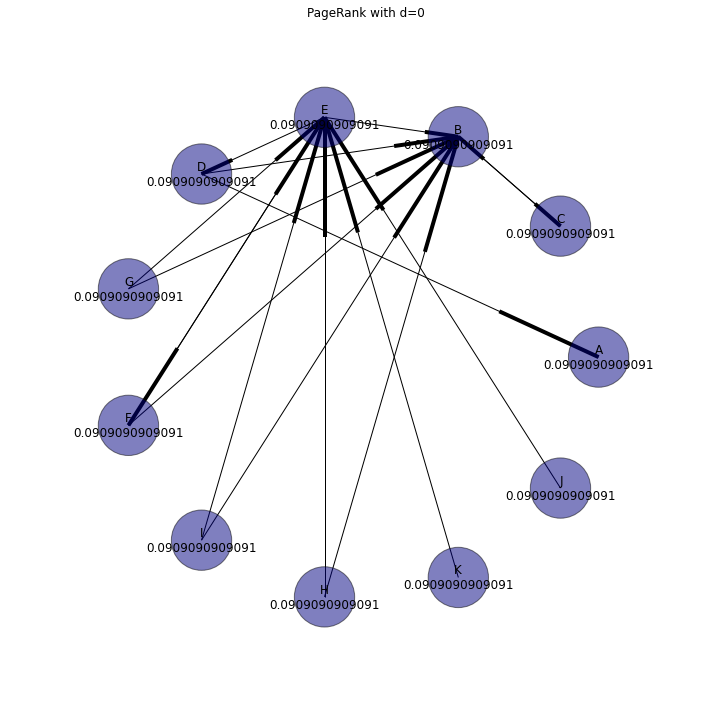

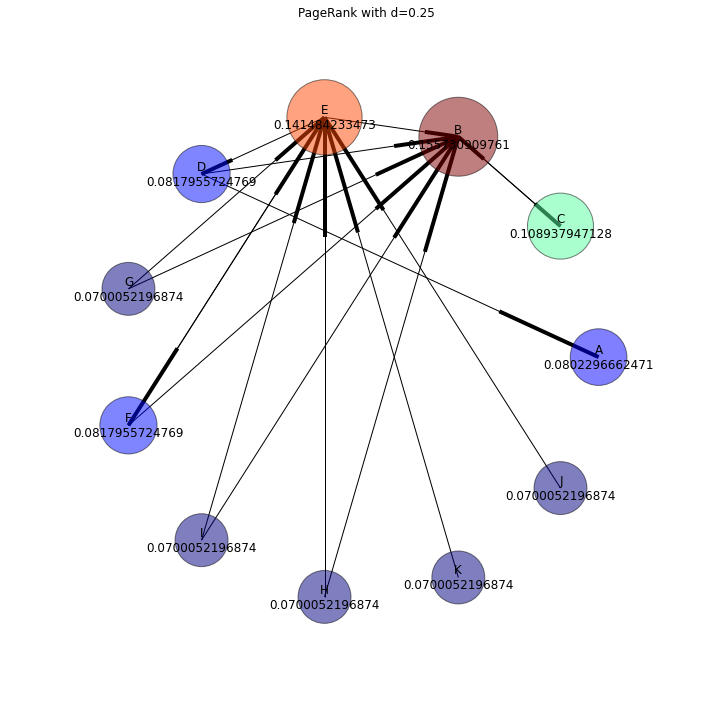

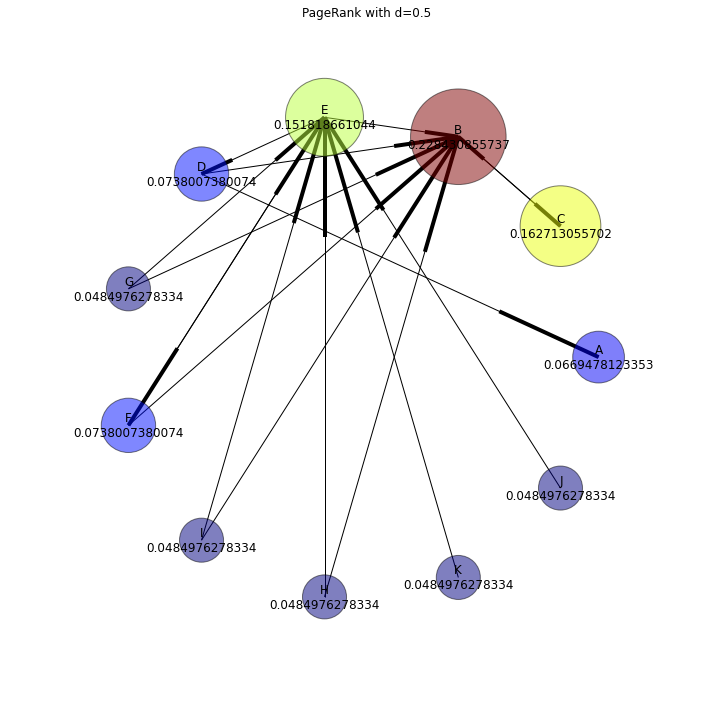

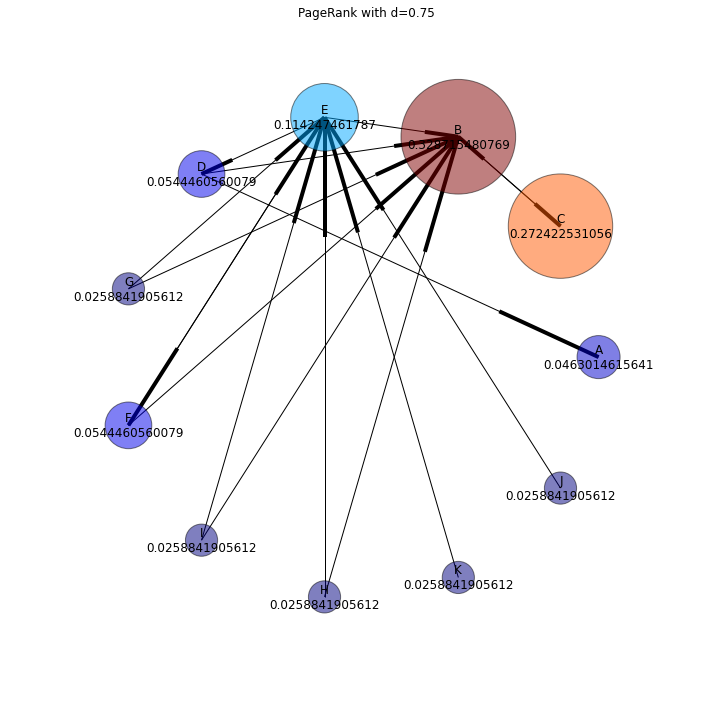

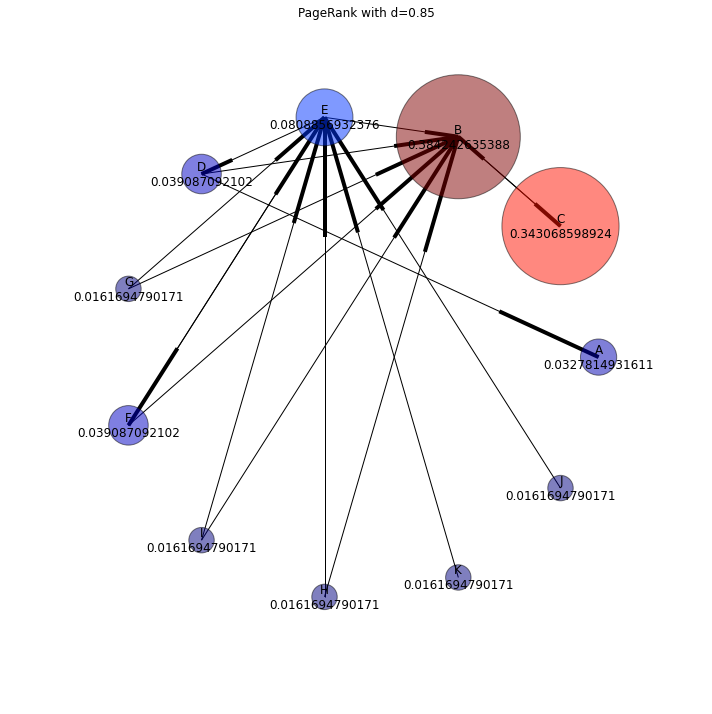

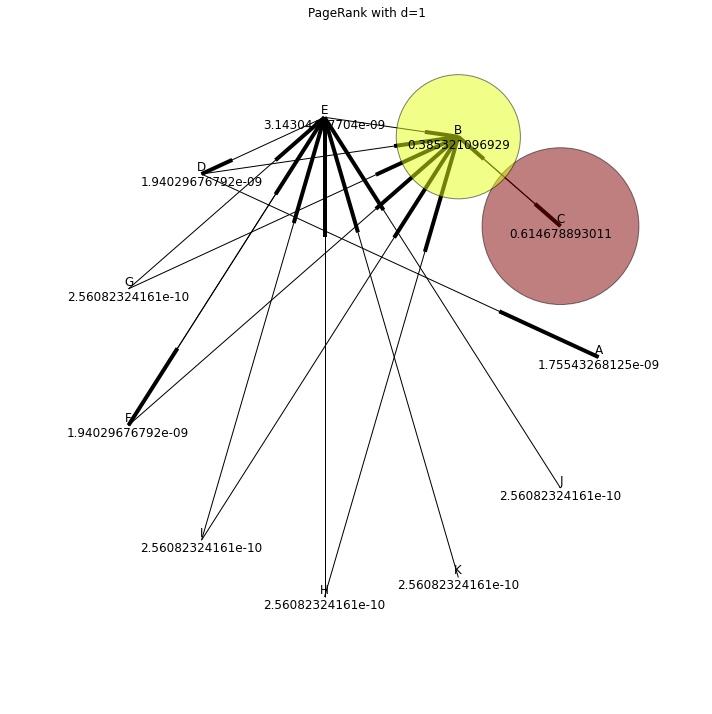

In [262]:
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

# Draw graphs
def draw(edges, scores, d):
    plt.figure(figsize=(10, 10))

    # initialize directed graph
    DG = nx.DiGraph()

    # add edges
    for edge in edges:
        DG.add_edge(edge[0], edge[1])    
    
    node_size = [scores[n]*40000 for n in DG.nodes()]

    graph_pos = nx.circular_layout(DG)

    # set labels
    labels = {}    
    for node in DG.nodes():
        labels[node] = '{}\n{}'.format(node, scores[node])

    # draw graph
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, node_color=node_size, alpha = 0.5)
    nx.draw_networkx_edges(DG, graph_pos, edge_color = 'black', arrows = True)
    nx.draw_networkx_labels(DG, graph_pos, labels=labels, font_size = 12)

    # show graph
    plt.title("PageRank with d={}".format(d))
    plt.axis('off')
    plt.tight_layout()
    plt.show()    

# Take filename, damping factor as input to produce plots by drawing graphs
def plot(f, d):
    edges = []
    scores = {}
    
    for line in open(f).read().strip().split('\n'):
        nid, nodes_score = line.split('\t') # Parse the line into the main node id and the nodes_score string
        
        nid = nid.replace('"', '') # Remove double quotes from node name
        
        nodes, score = map(ast.literal_eval, nodes_score.strip('"').split('|')) # Parse nodes_score string into nodes and score
        
        edges.extend([(nid, n) for n in nodes.keys()]) # For each node in nodes, add an edge from main node id
        scores[nid] = score # Set the score for the main node id
        
    draw(edges, scores, d) # Send our edges and scores and damping factor to the final draw function

D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    f = '92d{}.txt'.format(d)
    plot(f, d)

##HW 9.3

###HW 9.3 - Problem Statement

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


###HW 9.3 - Implementation details
Unlike the locally-run jobs shown in the previous problems, we need to deal with the problem of multiple reducers here.  Instead of relying on all mappers and reducers having access to the running total for the dangling mass the way we did earlier, we'll create a second job that aggregates this total separately.  That way, the main job can focus only on streaming the intermediate results to S3 while this second (much smaller) job streams data through the driver.  The tradeoff here is that we need a more complex driver, since we can't rely on MRJob itself to deal with the iterations. For brevity, we've also omitted the initial job that calculates how many nodes we have, since we already know that aspect of these datasets.  If we didn't know that in advance, running the job to figure it out would be a trivial additional step.

###HW 9.3 - First pass job
Add any dangling nodes to the list (with empty dictionaries of associated edges) and evenly distribute starting mass across all nodes

In [48]:
%%writefile mrpagerankfirstpass.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRankFirstPass(MRJob):
    
    def configure_options(self):
        super(mrPageRankFirstPass, self).configure_options()
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')

    def mapper_setup(self, nid, nodes_score):
        nodes_score = nodes_score.strip('\n')
        nid, nodes = nodes_score.split('\t')
        yield str(nid), nodes
        nodes=eval(nodes)
        for n,w in nodes.iteritems():
            yield str(n),'{}'    
        
    def reducer_setup(self, nid, values):
        nodes={}
        for v in values:
            v=eval(v)
            nodes.update(v)
        score = 1/float(self.options.N)
        yield str(nid),str(nodes)+"|"+str(score)
    
            
    def steps(self):
        return (
                #Init step - add dangling nodes as separate stripes and distributes
                #starting mass evenly
                [MRStep(mapper = self.mapper_setup,
                       reducer=self.reducer_setup)] )
    
if __name__ == '__main__':
    mrPageRankFirstPass.run()

Overwriting mrpagerankfirstpass.py


###HW 9.3 - Main pagerank job
This is similar to the code above, but runs one job per iteration rather than treating each iteration as a step within the single job

In [52]:
%%writefile mrpagerank.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class mrPageRank(MRJob):
    
    def configure_options(self):
        super(mrPageRank, self).configure_options()
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
        self.add_passthrough_option('--dangling', default=0, type=float,
                                    help='What dangling mass do we have?')
    
    def mapper_distribute_weights(self, _, line):
        line=line.strip('\n')
        nid,nodes_score=line.split('\t')
        #nodes_score=eval(nodes_score) #Comment this out when running locally
        nodes,score=nodes_score.split('|')
        #nid=eval(nid)#Comment this out when running locally
        nodes=eval(nodes)
        score=float(score)
        # pass along graph structure
        yield str(nid), ('node', nodes)

        #dispense mass from current node evenly across all linked nodes
        for n, w in nodes.iteritems():
            yield str(n), ('score', score*w/len(nodes))        
    
    def reducer_gather_weights(self, nid, values):
        nodes={}
        partial_score = 0

        for typ, value in values:
            if typ == 'node':
                nodes = value
            elif typ == 'score':
                partial_score += value

        N = self.options.N
        d = self.options.d
        mass=self.options.dangling
        new_mass=float(mass/N)

        score = (1-d)/float(N) + d*float(partial_score+new_mass)
    
        yield str(nid), str(nodes)+"|"+str(score)
    
            
    def steps(self):
        return (
                #Main step - redistribute and gather weights
                [MRStep(mapper = self.mapper_distribute_weights
                       ,reducer = self.reducer_gather_weights
                       )
                ]
        )
    
if __name__ == '__main__':
    mrPageRank.run()

Overwriting mrpagerank.py


###HW 9.3 - Add up dangling mass
This job iterates through the results of the previous job and totals the mass associated with dangling nodes.  This can then be passed back to the main pagerank job as a parameter for the subsequent iteration.

In [53]:
%%writefile mrpageranksumweight.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankSumWeight(MRJob):

    def mapper(self, _, line):
        line=line.strip('\n')
        nid,nodes_score=line.split('\t')
        #nodes_score=eval(nodes_score) #comment this out when running locally
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)


        # pass mass associated with dangling nodes
        if len(nodes)==0:
            yield _,score
     
    
    def reducer(self, nid, values):
        mass = sum([i for i in values])
        
        #Emit total dangling mass
        yield None, str(mass)
    
            
    def steps(self):
        return (
                #Main step - redistribute and gather weights
                [MRStep(mapper = self.mapper
                       ,reducer = self.reducer
                       )
                ]
        )
    
if __name__ == '__main__':
    mrPageRankSumWeight.run()

Overwriting mrpageranksumweight.py


###HW 9.3 - System Test Local Driver
Before we run our code on the full dataset, we run it again on the test dataset from 9.1 in EMR for a few iterations to ensure everything is working. In addition, we'll print out some intermediate results to compare to our upcoming EMR version.

In [55]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=40
input_dir_prefix='PageRank-test'
nodes=11 #We already know this, but we could run our init job to calculate it on the fly
dangling_mass=0
d=0.85
current_iteration=1
input_directory=input_dir_prefix+'.txt'
output_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration))

mr_job = mrPageRankFirstPass(args=[input_directory,'--no-strict-protocols','--N',str(nodes)])

#First job only runs once, expands graph, and evenly distributes starting mass
total_score=0
with mr_job.make_runner() as runner: 
    runner.run()
    #Stream output locally
    with open(output_directory, 'w+') as f:
        for line in runner.stream_output():
            #print line.strip()
            nid,stripe =  mr_job.parse_output_line(line)
            _,score=stripe.split("|")
            total_score+=eval(score)
            output=str(nid)+'\t'+str(stripe)+'\n'
            #print output
            f.write(output)

dangling_mass=0
mr_job3 = mrPageRankSumWeight(args=[output_directory,
                      '--no-strict-protocols'])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        #print line.strip()
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

        
current_iteration+=1
while current_iteration<=num_iterations:
    input_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration-1))
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(current_iteration))
    
    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=[input_directory,
                              '--no-strict-protocols',
                              '--d',d,
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass)])


    total_score=0
    with mr_job2.make_runner() as runner2: 
        runner2.run()
        #Stream output locally
        with open(output_directory, 'w+') as f:
            if current_iteration in [2,3,40]:
                print "Iteration {0}".format(str(current_iteration))
            for line in runner2.stream_output():
                if current_iteration in [2,3,40]:
                    #pass
                    print line.strip()
                nid,stripe =  mr_job.parse_output_line(line)
                _,score=stripe.split("|")
                total_score+=eval(score)
                output=str(nid)+'\t'+str(stripe)+'\n'
                f.write(output)
            if current_iteration in [2,3,40]:
                print ""
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[output_directory,
                          '--no-strict-protocols'])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    #print "Dangling Mass: "+str(dangling_mass)
    current_iteration+=1
    #print ""

print "ALL DONE"


Iteration 2
"A"	"{}|0.0592975206612"
"B"	"{'C': 1}|0.316873278237"
"C"	"{'B': 1}|0.0979338842975"
"D"	"{'A': 1, 'B': 1}|0.0464187327824"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.329752066116"
"F"	"{'B': 1, 'E': 1}|0.0464187327824"
"G"	"{'B': 1, 'E': 1}|0.0206611570248"
"H"	"{'B': 1, 'E': 1}|0.0206611570248"
"I"	"{'B': 1, 'E': 1}|0.0206611570248"
"J"	"{'E': 1}|0.0206611570248"
"K"	"{'E': 1}|0.0206611570248"

Iteration 3
"A"	"{}|0.0379464062109"
"B"	"{'C': 1}|0.260690896569"
"C"	"{'B': 1}|0.28756073128"
"D"	"{'A': 1, 'B': 1}|0.111648196845"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0994133483597"
"F"	"{'B': 1, 'E': 1}|0.111648196845"
"G"	"{'B': 1, 'E': 1}|0.0182184447784"
"H"	"{'B': 1, 'E': 1}|0.0182184447784"
"I"	"{'B': 1, 'E': 1}|0.0182184447784"
"J"	"{'E': 1}|0.0182184447784"
"K"	"{'E': 1}|0.0182184447784"

Iteration 40
"A"	"{}|0.0327814931627"
"B"	"{'C': 1}|0.384587199891"
"C"	"{'B': 1}|0.342724034413"
"D"	"{'A': 1, 'B': 1}|0.0390870921036"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0808856932407"
"F"	"{'B': 1, '

###HW 9.3 - System Test EMR Driver
Now that we've confirmed this new archtecture reproduces our results from 9.1 and we know what our intermediate results should look like, we can run the same job again on EMR. This requires a modified driver.

In [21]:
## HW9.3 - Test dataset, running in EMR
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=3
input_dir_prefix='PageRank-test'
nodes=11 #We already know this, but we could run our init job to calculate it on the fly
dangling_mass=0
d=0.85
current_iteration=1

input_dir_prefix='PageRank-test'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
output_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
cluster='j-1K47D3ANROPM1'

mr_job = mrPageRankFirstPass(args=[
        '-r','emr',
        input_directory,
        '--no-strict-protocols',
        '--output-dir',output_directory,
        '--emr-job-flow-id', cluster,
        '--no-output',
        '--N',str(nodes)
        ])

#First job only runs once, expands graph, and evenly distributes starting mass
with mr_job.make_runner() as runner: 
    runner.run()

dangling_mass=0
mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        #print line.strip()
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

#dangling_mass=0.0909090909091   
current_iteration+=1
#current_iteration=2
while current_iteration<=num_iterations:
    print current_iteration
    input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(current_iteration-1))
    output_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
    
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=['-r','emr',
                              input_directory,
                              '--no-strict-protocols',
                              '--d',str(d),
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass),
                              '--output-dir',output_directory,
                              '--emr-job-flow-id', cluster,
                              '--no-output'])


    with mr_job2.make_runner() as runner2: 
        runner2.run()
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job3.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    #print "Dangling Mass: "+str(dangling_mass)
    current_iteration+=1

print "ALL DONE"


2
3
ALL DONE


For brevity, we haven't included all the results of the system test here.  Manually spot-checking the output files confirms that this EMR version of the implementation is working, so now we can run it on the full dataset.

###HW 9.3 - Running the full job

In [23]:
## HW9.3 - Full dataset, running in EMR
%reload_ext autoreload
%autoreload 2
from mrpagerank import mrPageRank
from mrpagerankfirstpass import mrPageRankFirstPass
from mrpageranksumweight import mrPageRankSumWeight
from __future__ import division

num_iterations=10
input_dir_prefix='all-pages-indexed-out'
nodes=5781290 #We already know this, but we could run our init job to calculate it on the fly
dangling_mass=0
d=0.85
current_iteration=1

input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'.txt'
output_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
cluster='j-QDJ8C8U3MWWU'

mr_job = mrPageRankFirstPass(args=[
        '-r','emr',
        input_directory,
        '--no-strict-protocols',
        '--output-dir',output_directory,
        '--emr-job-flow-id', cluster,
        '--no-output',
        '--N',str(nodes)
        ])

#First job only runs once, expands graph, and evenly distributes starting mass
with mr_job.make_runner() as runner: 
    runner.run()

mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])

with mr_job3.make_runner() as runner3: 
    runner3.run()
    for line in runner3.stream_output():
        _,partial_mass =  mr_job.parse_output_line(line)
        dangling_mass+=eval(partial_mass)

current_iteration+=1
while current_iteration<=num_iterations:
    print current_iteration
    input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}/'.format(str(current_iteration-1))
    output_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Output{0}'.format(str(current_iteration))
    
    #Second job does the main pagerank calculation
    mr_job2 = mrPageRank(args=['-r','emr',
                              input_directory,
                              '--no-strict-protocols',
                              '--d',str(d),
                              '--N',str(nodes),
                              '--dangling',str(dangling_mass),
                              '--output-dir',output_directory,
                              '--emr-job-flow-id', cluster,
                              '--no-output'])


    with mr_job2.make_runner() as runner2: 
        runner2.run()
    
    #Third job aggregates the dangling mass
    dangling_mass=0
    mr_job3 = mrPageRankSumWeight(args=[
        '-r','emr',
        output_directory+'/',
        '--no-strict-protocols',
        '--no-output',
        '--emr-job-flow-id', cluster])
    
    with mr_job3.make_runner() as runner3: 
        runner3.run()
        for line in runner3.stream_output():
            _,partial_mass =  mr_job3.parse_output_line(line)
            dangling_mass+=eval(partial_mass)
            
    #print "Dangling Mass: "+str(dangling_mass)
    current_iteration+=1

print "ALL DONE"


2
3
4
5
6
7
8
9
10
ALL DONE


### HW9.3 - Organize the results
In theory, the most scalable way to handle the final sorting would be to create another mapreduce job.  In the interest of time and EMR costs, we've instead done this locally.

In [125]:
#HW9.3 - Download results
! mkdir ./wiki_5_iterations
! aws s3 cp --recursive s3://hamlin-mids-261/all-pages-indexed-outOutput5/ ./wiki_5_iterations 
! mkdir ./wiki_10_iterations
! aws s3 cp --recursive s3://hamlin-mids-261/all-pages-indexed-outOutput10/ ./wiki_10_iterations 

download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/_SUCCESS to wiki_10_iterations/_SUCCESS
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00001 to wiki_10_iterations/part-00001
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00000 to wiki_10_iterations/part-00000
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00002 to wiki_10_iterations/part-00002
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00003 to wiki_10_iterations/part-00003
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00004 to wiki_10_iterations/part-00004
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00005 to wiki_10_iterations/part-00005
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00006 to wiki_10_iterations/part-00006
download: s3://hamlin-mids-261/all-pages-indexed-outOutput10/part-00008 to wiki_10_iterations/part-00008
download: s3://hamlin-mids-261/all-pages-indexed-outOutput1

In [126]:
#HW 9.3 - Sort wikipedia results and extract top 100 pages for each
import os

def top_100(folder):
    files=os.listdir('./'+folder)[1:]
    files=['./'+folder+'/'+i for i in files]

    num_results=100
    output=[]
    for result in files:
        with open(result,'r') as f:
            for line in f.readlines():
                #print line
                line=line.strip('\n')
                nid,nodes_score=line.split('\t')
                nid=eval(nid)
                nodes_score=eval(nodes_score)
                nodes,score=nodes_score.split('|')
                score=float(score)
                output.append((score,nid))
                if len(output)>num_results:
                    output.sort(key=lambda x: -float(x[0]))
                    output=output[:num_results]

    output.sort(key=lambda x: -float(x[0]))

    with open(folder+'SortResults.txt','w') as f:
        for i in output:
            f.writelines(str(i)+'\n')
            #print i

top_100('wiki_5_iterations')
top_100('wiki_10_iterations')

In [128]:
# HW 9.3 - Load index into memory so we can look things up
word_dict={}
node_dict={}
with open('indices.txt') as f:
    for line in f.readlines():
        word,node_id,_,_=line.strip().split('\t')
        node_dict[node_id]=word #Enables us to find words by ID
        word_dict[word]=node_id #Enables us to find IDs by word

In [145]:
# HW 9.3 - Prettify and display results for top pages after 5 iterations
scores_5=[]
print "Top 100 pages after 5 iterations"
print "SCORE    |  ID - TITLE"
print "----------------------------------"
with open('wiki_5_iterationsSortResults.txt','r') as f:
    for line in f.readlines():
        score,nid=eval(line)
        scores_5.append(score)
        print '{0:3.6f} |  {1} - {2}  '.format(score,int(nid),node_dict[nid])

Top 100 pages after 5 iterations
SCORE    |  ID - TITLE
----------------------------------
0.026193 |  13455888 - United States  
0.011438 |  1184351 - Animal  
0.011243 |  4695850 - France  
0.010776 |  5051368 - Germany  
0.008472 |  6076759 - India  
0.008276 |  4196067 - England  
0.008261 |  1384888 - Arthropod  
0.008075 |  6113490 - Insect  
0.008068 |  2437837 - Canada  
0.007765 |  6172466 - Iran  
0.006547 |  13425865 - United Kingdom  
0.006294 |  6416278 - Japan  
0.006212 |  6237129 - Italy  
0.006165 |  10390714 - Poland  
0.005860 |  1516699 - Australia  
0.005850 |  7835160 - List of countries  
0.005846 |  14112583 - World War II  
0.005772 |  7576704 - Lepidoptera  
0.005754 |  15164193 - village  
0.005687 |  13432150 - United States Census Bureau  
0.005609 |  9276255 - National Register of Historic Places  
0.005541 |  7902219 - List of sovereign states  
0.005382 |  2155467 - Brazil  
0.005365 |  3191491 - Countries of the world  
0.005131 |  11147327 - Romania  


In [146]:
# HW 9.3 - Prettify and display results for top pages after 10 iterations
scores_10=[]
print "Top 100 pages after 10 iterations"
print "SCORE    |  ID - TITLE"
print "----------------------------------"
with open('wiki_10_iterationsSortResults.txt','r') as f:
    for line in f.readlines():
        score,nid=eval(line)
        scores_10.append(score)
        print '{0:3.6f} |  {1} - {2}  '.format(score,int(nid),node_dict[nid])

Top 100 pages after 10 iterations
SCORE    |  ID - TITLE
----------------------------------
0.321667 |  13455888 - United States  
0.137224 |  4695850 - France  
0.134542 |  1184351 - Animal  
0.131372 |  5051368 - Germany  
0.102965 |  6076759 - India  
0.101892 |  4196067 - England  
0.100011 |  2437837 - Canada  
0.097023 |  1384888 - Arthropod  
0.094844 |  6113490 - Insect  
0.093708 |  6172466 - Iran  
0.082219 |  13425865 - United Kingdom  
0.076869 |  6416278 - Japan  
0.076689 |  6237129 - Italy  
0.076177 |  10390714 - Poland  
0.073394 |  14112583 - World War II  
0.072464 |  1516699 - Australia  
0.070358 |  13432150 - United States Census Bureau  
0.069385 |  7835160 - List of countries  
0.068384 |  15164193 - village  
0.067796 |  7576704 - Lepidoptera  
0.067129 |  7902219 - List of sovereign states  
0.066590 |  9276255 - National Register of Historic Places  
0.065716 |  2155467 - Brazil  
0.064025 |  3191491 - Countries of the world  
0.061658 |  11147327 - Romania  

Looking at these results, it appears that while the scores shift with the additional iterations, the top 100 results remain generally unchanged.  That said, the specific rankings of individual pages do move slightly from 5 iterations to 10, which makes sense given that we saw the same general behavior in the test set.

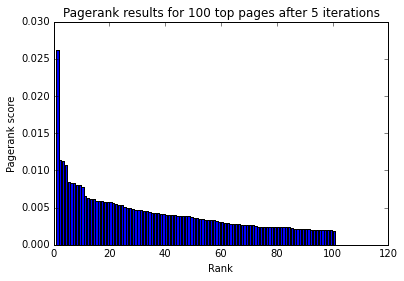

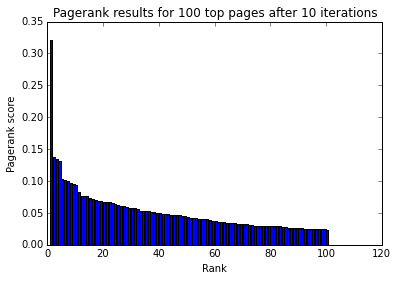

In [153]:
# HW 9.3 - Plot top pagerank scores for both versions
x=range(1,101)
plt.bar(x,scores_5)
plt.xlabel('Rank')
plt.ylabel('Pagerank score')
plt.title('Pagerank results for 100 top pages after 5 iterations')
plt.show()

plt.bar(x,scores_10)
plt.xlabel('Rank')
plt.ylabel('Pagerank score')
plt.title('Pagerank results for 100 top pages after 10 iterations')
plt.show()

As shown, the distribution of the top scores doesn't really change much with the additional iterations.  However, we do see that the values of the top scores are slightly higher after 10 iterations than after 5.

##HW 9.4

###9.4 - Problem Statement
Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described [here](http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf).

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the randomly generated network of 100 nodes (called randNet.txt) which are organized into ten topics, as described in the file randNet_topics.txt 

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold,so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

##End of Submission

In [87]:
%%writefile mrpageranksortresults.py
from math import exp, log
import bisect

from mrjob.job import MRJob
from mrjob.job import MRStep

class mrPageRankSortResults(MRJob):
    
    def configure_options(self):
        super(mrPageRankSortResults, self).configure_options()
        self.add_passthrough_option('--top', default=100, type=int,
                                    help='How many top nodes do we want to return?')

    def mapper_init(self):
        self.top_results=[]
               
    def mapper(self, _, line):
        line=line.strip('\n')
        nid,nodes_score=line.split('\t')
        #nodes_score=eval(nodes_score) #comment this out when running locally
        nodes,score=nodes_score.split('|')
        nodes=eval(nodes)
        score=float(score)
        #take log to avoid issues with sorting scientific notation
        log_score=log(score)
        
        
        self.top_results.append((log_score,nid))
        if len(self.top_results)>self.options.top:
            self.top_results.sort(key=lambda x: -float(x[0]))
            self.top_results=self.top_results[-self.options.top:]

    def mapper_final(self):
        for log_score, nid in self.top_results:
            yield log_score, nid
            
    def reducer_final(self):
        for log_score, nid in self.top_results:
            yield nid, exp(log_score)
        
    def reducer(self, log_score, nids):
        for nid in nids:
            self.top_results.append((log_score,nid))
        if len(self.top_results)>self.options.top:
            self.top_results.sort(key=lambda x: -float(x[0]))
            self.top_results=self.top_results[-self.options.top:]
    
    def steps(self):
        return [MRStep(
                    mapper_init=self.mapper_init,
                    mapper=self.mapper,
                    mapper_final=self.mapper_final,
                    reducer_init=self.mapper_init
                    ,reducer=self.reducer
                    ,reducer_final=self.reducer_final,
                    jobconf={
                        'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                        'mapred.text.key.comparator.options': '-k1,1rn',
                        'mapred.reduce.tasks': 1
                            }
                        )
                ]
                
if __name__ == '__main__':
    mrPageRankSortResults.run()

Overwriting mrpageranksortresults.py


In [88]:
%reload_ext autoreload
%autoreload 2
from mrpageranksortresults import mrPageRankSortResults

cluster='j-2BS8O2CWL2MDJ'
num_results=5
input_dir_prefix='PageRank-testOutput2'
input_directory='s3://hamlin-mids-261/'+input_dir_prefix+'/'
output_directory='s3://hamlin-mids-261/'+input_dir_prefix+'Sorted'

#Second job does the main pagerank calculation
mr_job = mrPageRankSortResults(args=['-r','emr',
                          input_directory,
                          '--no-strict-protocols',
                          '--top',str(num_results),
                          '--output-dir',output_directory,
                          '--emr-job-flow-id', cluster,
                          '--no-output'])


with mr_job.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

ERROR:mrjob.emr:Job on job flow j-2BS8O2CWL2MDJ failed with status WAITING: Cluster ready after last step failed.


Exception: Operation requires job flow to terminate, but it may never do so.

In [83]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from mrpageranksortresults import mrPageRankSortResults

num_results=5

input_dir_prefix='PageRank-testOutput40'
input_directory=input_dir_prefix+'.txt'
output_directory=input_dir_prefix+'Sort.txt'

mr_job = mrPageRankSortResults(args=[input_directory,'--no-strict-protocols',
                             '--top',str(num_results)])
       
#First Init job figures out how many nodes we have
with mr_job.make_runner() as runner:
    runner.run()
    with open(output_directory, 'w+') as f:
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

('G', 0.016169479017299995)
('H', 0.016169479017299995)
('I', 0.016169479017299995)
('J', 0.016169479017299995)
('K', 0.016169479017299995)
